In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [7]:
df = pd.read_csv("/content/air_quality_health_impact_data.csv")
df.head()

,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
0,1,187.270059,295.853039,13.038560,6.639263,66.161150,54.624280,5.150335,84.424344,6.137755,7,5,1,97.244041,0.0
1,2,475.357153,246.254703,9.984497,16.318326,90.499523,169.621728,1.543378,46.851415,4.521422,10,2,0,100.000000,0.0
2,3,365.996971,84.443191,23.111340,96.317811,17.875850,9.006794,1.169483,17.806977,11.157384,13,3,0,100.000000,0.0
3,4,299.329242,21.020609,14.273403,81.234403,48.323616,93.161033,21.925276,99.473373,15.302500,8,8,1,100.000000,0.0
4,5,78.009320,16.987667,152.111623,121.235461,90.866167,241.795138,9.217517,24.906837,14.534733,9,0,1,95.182643,0.0


In [8]:
df.dropna(inplace=True)
df = df.select_dtypes(include=[np.number])

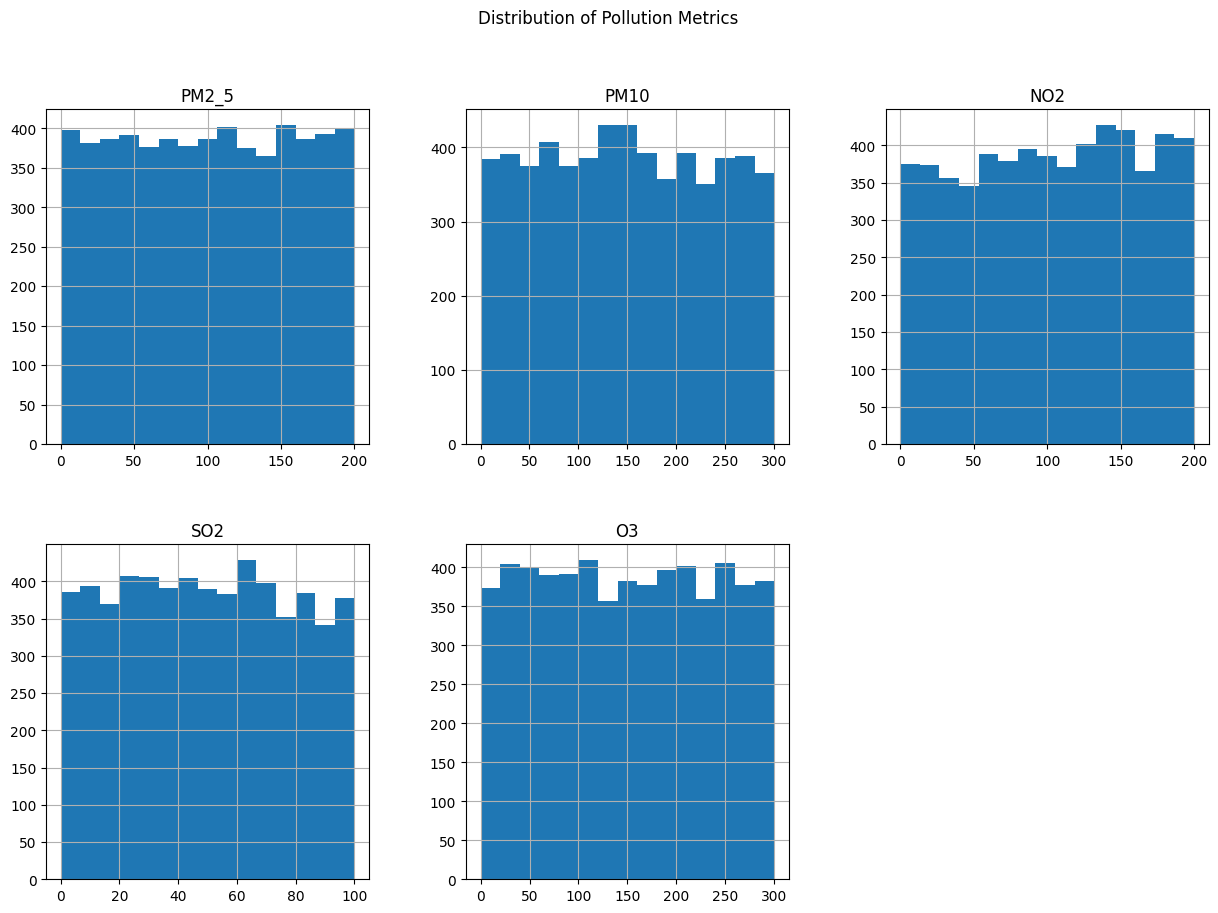

In [9]:
pollution_cols = ["PM2_5", "PM10", "NO2", "SO2", "O3"]
df[pollution_cols].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle("Distribution of Pollution Metrics")
plt.show()

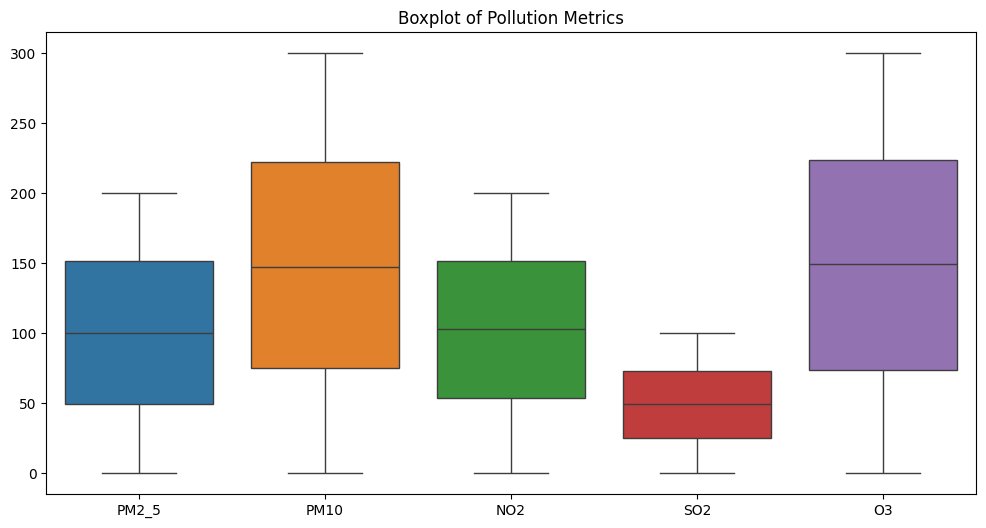

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[pollution_cols])
plt.title("Boxplot of Pollution Metrics")
plt.show()

In [11]:
X = df[["PM2_5", "PM10", "NO2", "SO2", "O3"]]  # Example features
y = df["HealthImpactScore"]  # Using 'HealthImpactScore' as the target variable

# 7. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R2 Score:", r2_score(y_test, y_pred_lr))
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost R2 Score:", r2_score(y_test, y_pred_xgb))



Linear Regression R2 Score: 0.12170163707015103
Random Forest R2 Score: 0.07019723661572042
XGBoost R2 Score: 0.044756546637614525


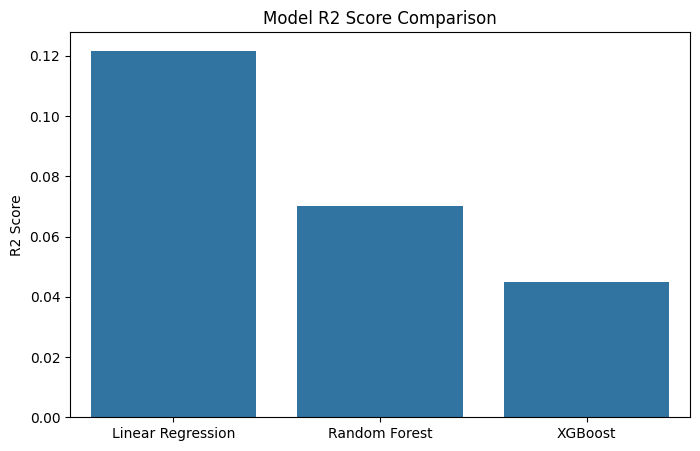

In [15]:
models = ["Linear Regression", "Random Forest", "XGBoost"]
scores = [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf), r2_score(y_test, y_pred_xgb)]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=scores)
plt.title("Model R2 Score Comparison")
plt.ylabel("R2 Score")
plt.show()

In [16]:
from sklearn.feature_selection import mutual_info_regression

# Set features and target
X = df.drop(columns=["RecordID", "HealthImpactScore", "HealthImpactClass"])
y = df["HealthImpactScore"]

# Compute Mutual Information
mi_scores = mutual_info_regression(X, y, random_state=42)

# Create a pandas Series of MI scores
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Display sorted MI scores
print("Mutual Information Scores:")
print(mi_series)

# Select top features with MI > 0
selected_features_mi = mi_series[mi_series > 0].index.tolist()
print("\nSelected Features based on Mutual Information:")
print(selected_features_mi)


Mutual Information Scores:
AQI                    0.409174
PM2_5                  0.027918
HospitalAdmissions     0.022460
PM10                   0.020487
O3                     0.010492
CardiovascularCases    0.007880
NO2                    0.003140
WindSpeed              0.001888
Humidity               0.000000
Temperature            0.000000
SO2                    0.000000
RespiratoryCases       0.000000
dtype: float64

Selected Features based on Mutual Information:
['AQI', 'PM2_5', 'HospitalAdmissions', 'PM10', 'O3', 'CardiovascularCases', 'NO2', 'WindSpeed']


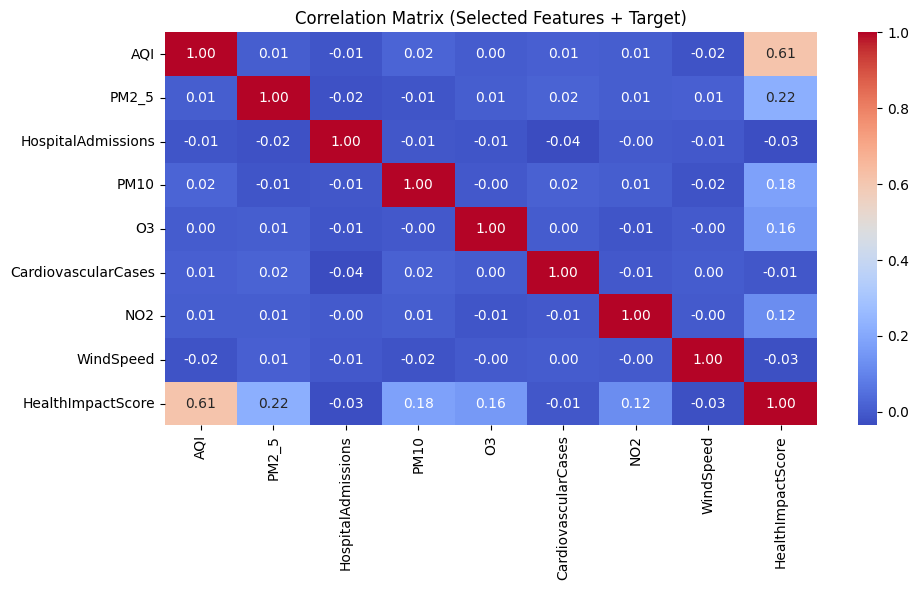


Highly Correlated Feature Pairs (|corr| > 0.9):
None found


In [17]:
# Add target back to selected features
corr_df = df[selected_features_mi + ["HealthImpactScore"]]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Selected Features + Target)")
plt.tight_layout()
plt.show()

# Identify and list high inter-feature correlations (|corr| > 0.9)
high_corr_pairs = []
for i in range(len(selected_features_mi)):
    for j in range(i + 1, len(selected_features_mi)):
        corr_val = corr_matrix.loc[selected_features_mi[i], selected_features_mi[j]]
        if abs(corr_val) > 0.9:
            high_corr_pairs.append((selected_features_mi[i], selected_features_mi[j], corr_val))

print("\nHighly Correlated Feature Pairs (|corr| > 0.9):")
print(high_corr_pairs if high_corr_pairs else "None found")

In [18]:
from sklearn.model_selection import train_test_split
# ✅ Selected Features
selected_features = [
    "AQI",
    "PM2_5",
    "PM10",
    "HospitalAdmissions",
    "O3",
    "CardiovascularCases"
]
target = "HealthImpactScore"

# Prepare X and y
X = df[selected_features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2. Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 3. XGBoost Regressor
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

#  Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE: {rmse:.4f}")

# Evaluate all models
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)


Linear Regression Results:
R² Score: 0.4918
RMSE: 9.7577

Random Forest Results:
R² Score: 0.9247
RMSE: 3.7565

XGBoost Results:
R² Score: 0.9211
RMSE: 3.8448


In [19]:
from sklearn.model_selection import RepeatedKFold, cross_val_score, learning_curve
from sklearn.metrics import make_scorer

# Selected features
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]
target = "HealthImpactScore"

X = df[features]
y = df[target]

# Initialize model
model = LinearRegression()

# 🔁 Repeated K-Fold Cross-Validation (like training over 'epochs')
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# Accuracy (R²) scores
r2_scores = cross_val_score(model, X, y, scoring='r2', cv=rkf)
rmse_scores = cross_val_score(model, X, y, scoring=make_scorer(mean_squared_error, squared=False), cv=rkf)

print(" Repeated K-Fold Results (25 'Epochs') for Linear Regression:")
print(f"R² Mean: {np.mean(r2_scores):.4f} | Std: {np.std(r2_scores):.4f}")
print(f"RMSE Mean: {np.mean(rmse_scores):.4f} | Std: {np.std(rmse_scores):.4f}")


 Repeated K-Fold Results (25 'Epochs') for Linear Regression:
R² Mean: 0.4754 | Std: 0.0185
RMSE Mean: nan | Std: nan


Repeated K-Fold Results (25 'Epochs') for Linear Regression:
Epoch 1/25: R² = 0.4918 | RMSE = 9.7577
Epoch 2/25: R² = 0.4651 | RMSE = 9.5175
Epoch 3/25: R² = 0.4773 | RMSE = 9.3429
Epoch 4/25: R² = 0.4686 | RMSE = 9.8524
Epoch 5/25: R² = 0.4830 | RMSE = 9.6440
Epoch 6/25: R² = 0.4781 | RMSE = 9.6819
Epoch 7/25: R² = 0.4648 | RMSE = 9.6410
Epoch 8/25: R² = 0.4929 | RMSE = 9.6498
Epoch 9/25: R² = 0.4185 | RMSE = 9.3133
Epoch 10/25: R² = 0.5092 | RMSE = 9.8942
Epoch 11/25: R² = 0.4735 | RMSE = 9.3475
Epoch 12/25: R² = 0.4636 | RMSE = 8.9353
Epoch 13/25: R² = 0.4718 | RMSE = 10.4381
Epoch 14/25: R² = 0.4782 | RMSE = 9.4455
Epoch 15/25: R² = 0.4903 | RMSE = 9.9313
Epoch 16/25: R² = 0.4834 | RMSE = 9.6348
Epoch 17/25: R² = 0.4623 | RMSE = 9.5153
Epoch 18/25: R² = 0.4788 | RMSE = 9.9426
Epoch 19/25: R² = 0.4746 | RMSE = 9.3962
Epoch 20/25: R² = 0.4865 | RMSE = 9.6378
Epoch 21/25: R² = 0.4854 | RMSE = 9.7536
Epoch 22/25: R² = 0.4583 | RMSE = 9.6254
Epoch 23/25: R² = 0.4420 | RMSE = 9.6428
Epoc

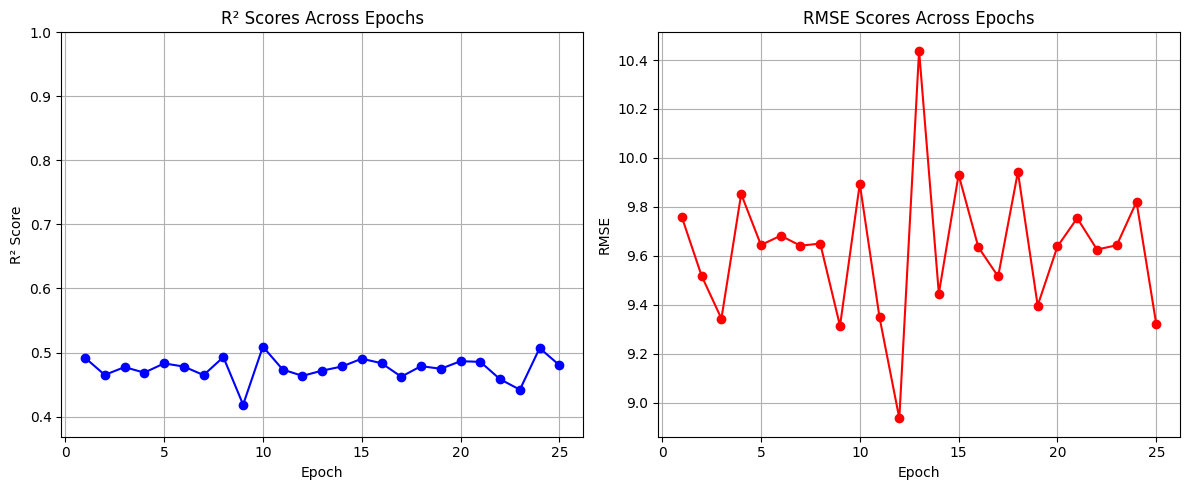

In [20]:
# Selected features
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]
target = "HealthImpactScore"

X = df[features].values
y = df[target].values

# Initialize model
model = LinearRegression()

# Repeated K-Fold Cross-Validation (25 folds: 5 splits * 5 repeats)
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

r2_scores = []
rmse_scores = []

print("Repeated K-Fold Results (25 'Epochs') for Linear Regression:")

for epoch, (train_index, test_index) in enumerate(rkf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print(f"Epoch {epoch}/25: R² = {r2:.4f} | RMSE = {rmse:.4f}")

# Summary printout
print("\nSummary:")
print(f"R² Mean: {np.mean(r2_scores):.4f} | Std: {np.std(r2_scores):.4f}")
print(f"RMSE Mean: {np.mean(rmse_scores):.4f} | Std: {np.std(rmse_scores):.4f}")

# Plotting results
epochs = np.arange(1, 26)

plt.figure(figsize=(12, 5))

# Plot R²
plt.subplot(1, 2, 1)
plt.plot(epochs, r2_scores, marker='o', linestyle='-', color='b')
plt.title("R² Scores Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)
plt.ylim([min(r2_scores) - 0.05, 1])  # optional, keep y-axis neat

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(epochs, rmse_scores, marker='o', linestyle='-', color='r')
plt.title("RMSE Scores Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()

Repeated K-Fold Results (25 'Epochs') for Random Forest Regression:
Epoch 1/25: R² = 0.9245 | RMSE = 3.7606
Epoch 2/25: R² = 0.9276 | RMSE = 3.5004
Epoch 3/25: R² = 0.9251 | RMSE = 3.5372
Epoch 4/25: R² = 0.9189 | RMSE = 3.8493
Epoch 5/25: R² = 0.9348 | RMSE = 3.4246
Epoch 6/25: R² = 0.9265 | RMSE = 3.6330
Epoch 7/25: R² = 0.9350 | RMSE = 3.3609
Epoch 8/25: R² = 0.9194 | RMSE = 3.8466
Epoch 9/25: R² = 0.9178 | RMSE = 3.5020
Epoch 10/25: R² = 0.9334 | RMSE = 3.6451
Epoch 11/25: R² = 0.9275 | RMSE = 3.4675
Epoch 12/25: R² = 0.9195 | RMSE = 3.4619
Epoch 13/25: R² = 0.9285 | RMSE = 3.8390
Epoch 14/25: R² = 0.9251 | RMSE = 3.5791
Epoch 15/25: R² = 0.9261 | RMSE = 3.7829
Epoch 16/25: R² = 0.9267 | RMSE = 3.6299
Epoch 17/25: R² = 0.9197 | RMSE = 3.6774
Epoch 18/25: R² = 0.9354 | RMSE = 3.4993
Epoch 19/25: R² = 0.9237 | RMSE = 3.5806
Epoch 20/25: R² = 0.9244 | RMSE = 3.6969
Epoch 21/25: R² = 0.9139 | RMSE = 3.9893
Epoch 22/25: R² = 0.9334 | RMSE = 3.3745
Epoch 23/25: R² = 0.9321 | RMSE = 3.364

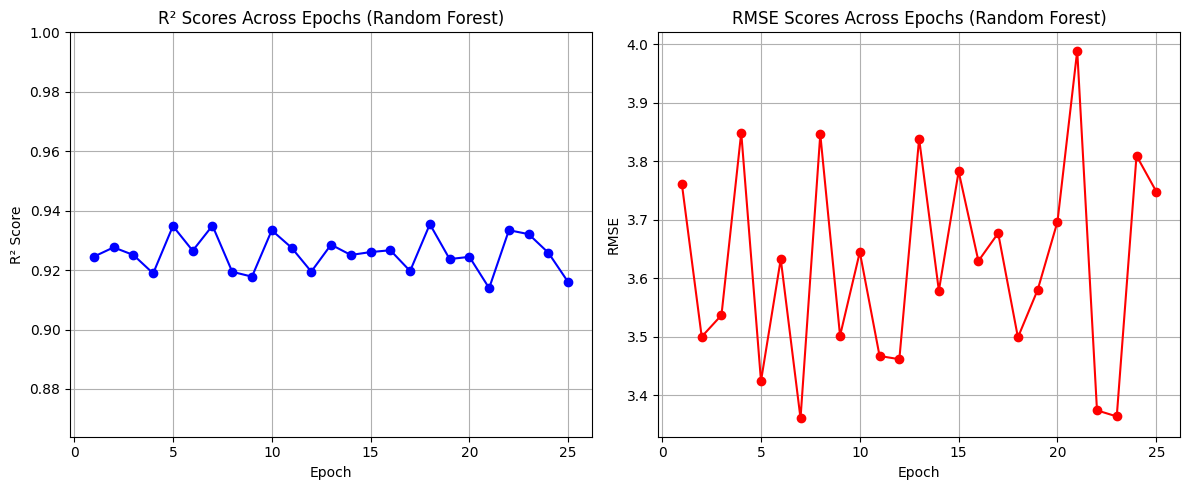

In [21]:
# Selected features
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]
target = "HealthImpactScore"

X = df[features].values
y = df[target].values

# Initialize Random Forest model
model = RandomForestRegressor(random_state=42)

# Repeated K-Fold Cross-Validation (25 folds: 5 splits * 5 repeats)
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

r2_scores = []
rmse_scores = []

print("Repeated K-Fold Results (25 'Epochs') for Random Forest Regression:")

for epoch, (train_index, test_index) in enumerate(rkf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print(f"Epoch {epoch}/25: R² = {r2:.4f} | RMSE = {rmse:.4f}")

# Summary printout
print("\nSummary:")
print(f"R² Mean: {np.mean(r2_scores):.4f} | Std: {np.std(r2_scores):.4f}")
print(f"RMSE Mean: {np.mean(rmse_scores):.4f} | Std: {np.std(rmse_scores):.4f}")

# Plotting results
epochs = np.arange(1, 26)

plt.figure(figsize=(12, 5))

# Plot R²
plt.subplot(1, 2, 1)
plt.plot(epochs, r2_scores, marker='o', linestyle='-', color='b')
plt.title("R² Scores Across Epochs (Random Forest)")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)
plt.ylim([min(r2_scores) - 0.05, 1])  # optional

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(epochs, rmse_scores, marker='o', linestyle='-', color='r')
plt.title("RMSE Scores Across Epochs (Random Forest)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()


Repeated K-Fold Results (25 'Epochs') for XGBoost Regression:
Epoch 1/25: R² = 0.9211 | RMSE = 3.8448
Epoch 2/25: R² = 0.9217 | RMSE = 3.6421
Epoch 3/25: R² = 0.9191 | RMSE = 3.6750
Epoch 4/25: R² = 0.9115 | RMSE = 4.0218
Epoch 5/25: R² = 0.9244 | RMSE = 3.6887
Epoch 6/25: R² = 0.9200 | RMSE = 3.7906
Epoch 7/25: R² = 0.9284 | RMSE = 3.5255
Epoch 8/25: R² = 0.9153 | RMSE = 3.9432
Epoch 9/25: R² = 0.9136 | RMSE = 3.5893
Epoch 10/25: R² = 0.9313 | RMSE = 3.7007
Epoch 11/25: R² = 0.9167 | RMSE = 3.7177
Epoch 12/25: R² = 0.9114 | RMSE = 3.6322
Epoch 13/25: R² = 0.9270 | RMSE = 3.8802
Epoch 14/25: R² = 0.9219 | RMSE = 3.6538
Epoch 15/25: R² = 0.9187 | RMSE = 3.9655
Epoch 16/25: R² = 0.9120 | RMSE = 3.9774
Epoch 17/25: R² = 0.9107 | RMSE = 3.8781
Epoch 18/25: R² = 0.9258 | RMSE = 3.7504
Epoch 19/25: R² = 0.9143 | RMSE = 3.7944
Epoch 20/25: R² = 0.9227 | RMSE = 3.7390
Epoch 21/25: R² = 0.9090 | RMSE = 4.1022
Epoch 22/25: R² = 0.9304 | RMSE = 3.4497
Epoch 23/25: R² = 0.9243 | RMSE = 3.5509
Epoc

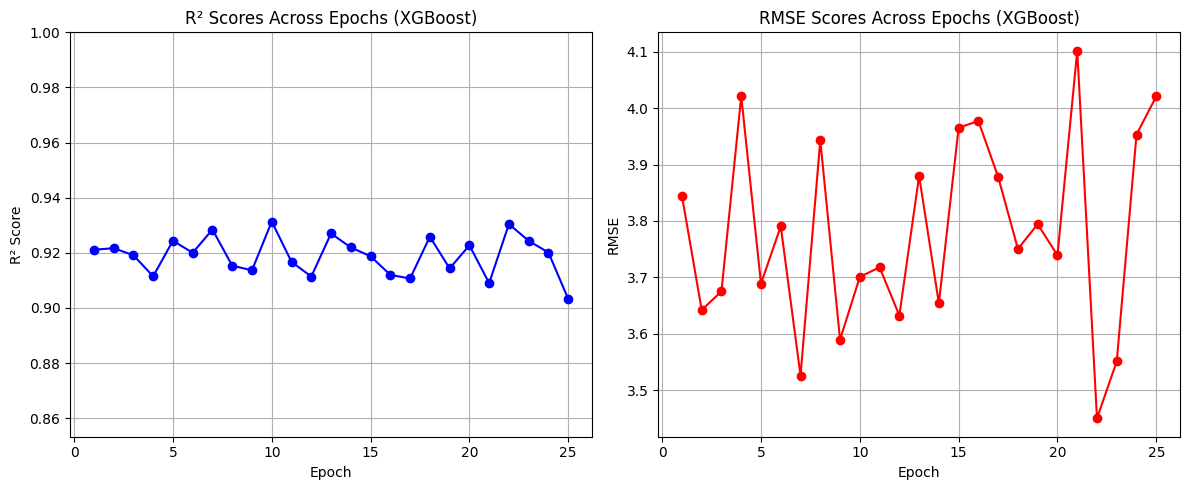

In [22]:
# Selected features
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]
target = "HealthImpactScore"

X = df[features].values
y = df[target].values

# Initialize XGBoost model
model = XGBRegressor(random_state=42, verbosity=0)

# Repeated K-Fold Cross-Validation (25 folds: 5 splits * 5 repeats)
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

r2_scores = []
rmse_scores = []

print("Repeated K-Fold Results (25 'Epochs') for XGBoost Regression:")

for epoch, (train_index, test_index) in enumerate(rkf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print(f"Epoch {epoch}/25: R² = {r2:.4f} | RMSE = {rmse:.4f}")

# Summary printout
print("\nSummary:")
print(f"R² Mean: {np.mean(r2_scores):.4f} | Std: {np.std(r2_scores):.4f}")
print(f"RMSE Mean: {np.mean(rmse_scores):.4f} | Std: {np.std(rmse_scores):.4f}")

# Plotting results
epochs = np.arange(1, 26)

plt.figure(figsize=(12, 5))

# Plot R²
plt.subplot(1, 2, 1)
plt.plot(epochs, r2_scores, marker='o', linestyle='-', color='b')
plt.title("R² Scores Across Epochs (XGBoost)")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)
plt.ylim([min(r2_scores) - 0.05, 1])

# Plot RMSE
plt.subplot(1, 2, 2)
plt.plot(epochs, rmse_scores, marker='o', linestyle='-', color='r')
plt.title("RMSE Scores Across Epochs (XGBoost)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()
